# Определение стоимости автомобилей

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install lightgbm -q

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv

### Загрузка и изучение данных.

In [3]:
df = pd.read_csv('/datasets/autos.csv')

In [4]:
display(df.head(20))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Предобработка данных

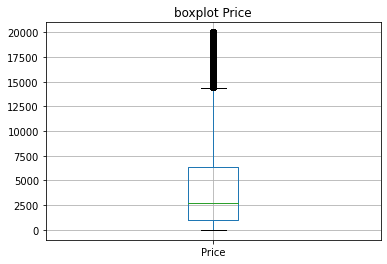

In [8]:
df.boxplot('Price');
plt.title('boxplot Price');
plt.show()

In [9]:
df.Price.quantile([.05, 0.95])

0.05      200.0
0.95    14600.0
Name: Price, dtype: float64

In [10]:
df.RegistrationMonth.value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

In [11]:
df.Kilometer.value_counts()

150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: Kilometer, dtype: int64

**Я обращал внимание на то, что в месяце регистрации есть 0. Но я не до конца понял как от него избавится. Я думал, что можно раскидать как то по остальным месяцами, но решил, что это не сыграет большой роли. В целом месяц регистрации машины не сильно важен, год - важен. Может и стоит удалить.**

1. Удаляем столбцы `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`, `PostalCode`, `RegistrationMonth` не виляющие на исследование.
2. Значение мощности (`Power`) рядового автомобиля не бывает ниже 25 и выше 500. Так что возьмем эти значения за границы. Значения ниже и выше наших границ - удалим.
3. Столбец `RegistrationYear`. Объективно присутсвуют выбросы т.к. минимальный год регстирации 1000. Ценообразование на раритетные машины годом выпуска ниже 1970 другое. Так что сделаем это значение нижней границей. Врехняя - 2016 год. Остальное удалим. 
4. В столбце с целевым признаком (`Price`) присутствуют выбросы. Цена не может быть ровна нулю. Считаю 5 и 95 квантили доверительным интервалом и удаляю строки со значением ниже 200 и выше 14600.
5. В столбцах `VehicleType`, `Model`, `FuelType`, `Gearbox`, `Repaired` большое количество пропусков. Качество модели может сильно ухудшится, если просто взять и удалить их т.к. Все эти параметры имеют большое значение для ценообразования. Значения в столбцах заменим на unknown.
6. В стобце `Kilometer` всего 13 значений. Изменим тип на `object`, что позволит нам сделать его категориальным признаком.
7. В столбце `Replace`  значения `petrol`, `gasoline` обзначают один тип топлива - `benzin`. Заменим.
 

In [12]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth'], axis = 1)

In [13]:
df = df.query('25 <= Power <= 500')
df = df.query('1970 <= RegistrationYear <= 2016')
df = df.query('200 <= Price <= 14600')

In [14]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Repaired'] = df['Repaired'].fillna('unknown')

In [15]:
df = df.replace(['petrol', 'gasoline'],['benzin', 'benzin'])

In [16]:
df['Kilometer'] = df['Kilometer'].astype('object')

In [17]:
df.duplicated().sum()

38056

In [18]:
df = df.drop_duplicates(keep='first').reset_index(drop=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236848 entries, 0 to 236847
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             236848 non-null  int64 
 1   VehicleType       236848 non-null  object
 2   RegistrationYear  236848 non-null  int64 
 3   Gearbox           236848 non-null  object
 4   Power             236848 non-null  int64 
 5   Model             236848 non-null  object
 6   Kilometer         236848 non-null  object
 7   FuelType          236848 non-null  object
 8   Brand             236848 non-null  object
 9   Repaired          236848 non-null  object
dtypes: int64(3), object(7)
memory usage: 18.1+ MB


In [20]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [21]:
df.describe()

,Price,RegistrationYear,Power
count,236848.000000,236848.000000,236848.000000
mean,4228.521465,2002.659376,118.282156
std,3599.918598,6.147510,50.307474
min,200.000000,1970.000000,25.000000
25%,1350.000000,1999.000000,77.000000
50%,2999.000000,2003.000000,110.000000
75%,6300.000000,2007.000000,144.000000
max,14600.000000,2016.000000,500.000000


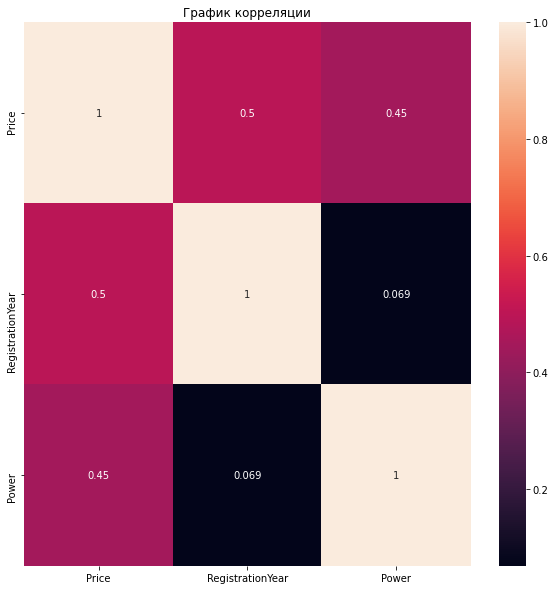

In [22]:
plt.figure(figsize=(10,10));
plt.title('График корреляции');
sns.heatmap(df.corr(), annot=True);

### Деление на выборки. Масштабирование и кодирование методом OHE признаков.

In [23]:
features = df.drop('Price', axis=1)
target = df['Price']

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 7, test_size=0.2)
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()
y_train_ohe = y_train.copy()
y_test_ohe = y_test.copy()
X_train_oe = X_train.copy()
X_test_oe = X_test.copy()
y_train_oe = y_train.copy()
y_test_oe = y_test.copy()


In [24]:
cat_1 = ['VehicleType', 'Gearbox', 'Model', 'FuelType']
cat_2 = ['Repaired', 'Brand', 'Kilometer']
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe.fit(X_train_ohe[cat_1])
X_train_ohe[ohe.get_feature_names_out()] = ohe.transform(X_train_ohe[cat_1])
X_test_ohe[ohe.get_feature_names_out()] = ohe.transform(X_test_ohe[cat_1])

In [25]:
ohe.fit(X_train_ohe[cat_2])
X_train_ohe[ohe.get_feature_names_out()] = ohe.transform(X_train_ohe[cat_2])
X_test_ohe[ohe.get_feature_names_out()] = ohe.transform(X_test_ohe[cat_2])

In [26]:
print(X_train_ohe.shape)
print(X_test_ohe.shape)
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(189478, 327)
(47370, 327)
(189478,)
(47370,)


**Не знаю причины, но когда я добавляю `Brand` в список `cat` и запускаю код, у меня выпадает ошибка о том, что ядро не работает. Поэтмоу пришлось вынести отдельно. Мне не очень нравится такое исполнение, но другого я не смог реализовать. Почему так может быть? И как можно сделать иначе?**

In [27]:
cat_1 = ['VehicleType', 'Gearbox', 'Model', 'FuelType']
cat_2 = ['Repaired', 'Brand', 'Kilometer']
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe.fit(X_train_oe[cat_1])
X_train_oe[cat_1] = oe.transform(X_train_oe[cat_1])
X_test_oe[cat_1] = oe.transform(X_test_oe[cat_1])

In [28]:
oe.fit(X_train_oe[cat_2])
X_train_oe[cat_2] = oe.transform(X_train_oe[cat_2])
X_test_oe[cat_2] = oe.transform(X_test_oe[cat_2])

In [29]:
num = ['RegistrationYear', 'Power']
scaler = StandardScaler()
scaler.fit(X_train[num])
X_train[num] = scaler.transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])
X_train_ohe[num] = scaler.transform(X_train_ohe[num])
X_test_ohe[num] = scaler.transform(X_test_ohe[num])
X_train_oe[num] = scaler.transform(X_train_oe[num])
X_test_oe[num] = scaler.transform(X_test_oe[num])

In [30]:
X_train_ohe = X_train_ohe.drop(cat_1, axis = 1)
X_test_ohe = X_test_ohe.drop(cat_1, axis = 1)
X_train_ohe = X_train_ohe.drop(cat_2, axis = 1)
X_test_ohe = X_test_ohe.drop(cat_2, axis = 1)

## Обучение моделей

### Функция скоринга

In [31]:
def rmse(target, pred):
    return mean_squared_error(target, pred)**0.5

rmse_scorer = make_scorer(rmse, greater_is_better = False)

### Линейная модель с кросс-валидацией.

In [32]:
%%time

model_lr = LinearRegression()
rmse = cross_val_score(model_lr, X_train_ohe, y_train_ohe, scoring = rmse_scorer, cv=4)
rmse_cv_lr_ohe = abs(rmse.mean())
print('RMSE при кросс-валидации:', rmse_cv_lr_ohe)

RMSE при кросс-валидации: 2067.724809983067
CPU times: user 1min 55s, sys: 2min 9s, total: 4min 5s
Wall time: 4min 5s


In [33]:
%%time

model_lr = LinearRegression()
rmse = cross_val_score(model_lr, X_train_oe, y_train_oe, scoring = rmse_scorer, cv=4)
rmse_cv_lr_oe = abs(rmse.mean())
print('RMSE при кросс-валидации:', rmse_cv_lr_oe)

RMSE при кросс-валидации: 2459.6123175264484
CPU times: user 506 ms, sys: 335 ms, total: 840 ms
Wall time: 879 ms


In [34]:
%%time

model_lr = LinearRegression()
model_lr.fit(X_train_ohe, y_train_ohe)

CPU times: user 36.6 s, sys: 39.6 s, total: 1min 16s
Wall time: 1min 16s


LinearRegression()

In [35]:
%%time

pred = model_lr.predict(X_test_ohe)
rmse_lr_ohe = mean_squared_error(y_test_ohe, pred)**0.5

CPU times: user 53.7 ms, sys: 27.9 ms, total: 81.6 ms
Wall time: 90.3 ms


In [36]:
%%time

model_lr = LinearRegression()
model_lr.fit(X_train_oe, y_train_oe)

CPU times: user 85.8 ms, sys: 46.1 ms, total: 132 ms
Wall time: 158 ms


LinearRegression()

In [37]:
%%time

pred = model_lr.predict(X_test_oe)
rmse_lr_oe = mean_squared_error(y_test_oe, pred)**0.5

CPU times: user 24.9 ms, sys: 24.4 ms, total: 49.3 ms
Wall time: 21.7 ms


### Случайный лес

In [38]:
%%time 

param = {'n_estimators': range(1,11),
         'max_depth': range(1,11)}

model_rf = RandomForestRegressor(random_state = 7)
randomizedsearch = RandomizedSearchCV(model_rf, param, random_state = 7, scoring = rmse_scorer)

rf_best = randomizedsearch.fit(X_train_oe, y_train_oe)
print(rf_best.best_estimator_)

RandomForestRegressor(max_depth=10, n_estimators=4, random_state=7)
CPU times: user 46.3 s, sys: 781 ms, total: 47.1 s
Wall time: 47.2 s


In [39]:
%%time

model_rf = RandomForestRegressor(max_depth = 10, n_estimators = 4, random_state = 7)
rmse = cross_val_score(model_rf, X_train_oe, y_train_oe, scoring = rmse_scorer, cv=4)
rmse_cv_rf_oe = abs(rmse.mean())
print('RMSE при кросс-валидации:', rmse_cv_rf_oe)

RMSE при кросс-валидации: 1603.2208617285376
CPU times: user 3.79 s, sys: 49.1 ms, total: 3.84 s
Wall time: 3.86 s


In [40]:
%%time

model_rf = RandomForestRegressor(max_depth = 10, n_estimators = 4, random_state = 7)
model_rf.fit(X_train_oe, y_train_oe)

CPU times: user 1.27 s, sys: 22.3 ms, total: 1.29 s
Wall time: 1.3 s


RandomForestRegressor(max_depth=10, n_estimators=4, random_state=7)

In [41]:
%%time

pred = model_rf.predict(X_test_oe)
rmse_rf_oe = mean_squared_error(y_test_oe, pred)**0.5 

CPU times: user 27.9 ms, sys: 630 µs, total: 28.6 ms
Wall time: 28.4 ms


### CatBoost

In [42]:
cat_b = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'Kilometer']
X_train[cat_b] = X_train[cat_b].astype('str')
X_test[cat_b] = X_test[cat_b].astype('str')


In [43]:
cv_df = Pool(data=X_train,
             label=y_train,
             cat_features=cat_b)
    
    
params = {"loss_function": 'RMSE', "learning_rate": 0.1, 'random_state': 7, 'depth': 10, 'iterations': 200, 'verbose': 10}
 
score_cat = cv(cv_df, params, fold_count=3)
rmse_cv_cat = score_cat['train-RMSE-mean'].min()
print('RMSE при кросс-валидации:', rmse_cv_cat)

Training on fold [0/3]
0:	learn: 5085.1391583	test: 5044.6258988	best: 5044.6258988 (0)	total: 657ms	remaining: 2m 10s
10:	learn: 2430.0798878	test: 2419.5573141	best: 2419.5573141 (10)	total: 5.59s	remaining: 1m 36s
20:	learn: 1713.7742673	test: 1718.1233666	best: 1718.1233666 (20)	total: 10.1s	remaining: 1m 26s
30:	learn: 1522.9737138	test: 1535.6165412	best: 1535.6165412 (30)	total: 14.9s	remaining: 1m 21s
40:	learn: 1463.9201305	test: 1483.1880955	best: 1483.1880955 (40)	total: 19.6s	remaining: 1m 15s
50:	learn: 1432.6565817	test: 1457.0240990	best: 1457.0240990 (50)	total: 24.3s	remaining: 1m 11s
60:	learn: 1413.7908107	test: 1442.9931531	best: 1442.9931531 (60)	total: 29.4s	remaining: 1m 7s
70:	learn: 1395.5366431	test: 1429.1752347	best: 1429.1752347 (70)	total: 34.4s	remaining: 1m 2s
80:	learn: 1381.8912627	test: 1419.6111305	best: 1419.6111305 (80)	total: 39.7s	remaining: 58.3s
90:	learn: 1368.9991000	test: 1410.5911040	best: 1410.5911040 (90)	total: 44.4s	remaining: 53.1s
100

In [44]:
cv_df = Pool(data=X_train_oe,
             label=y_train_oe)
    
    
params = {"loss_function": 'RMSE', "learning_rate": 0.1, 'random_state': 7, 'depth': 10, 'iterations': 200, 'verbose': 10}
 
score_cat_oe = cv(cv_df, params, fold_count=3)
rmse_cv_cat_oe = score_cat_oe['train-RMSE-mean'].min()
print('RMSE при кросс-валидации:', rmse_cv_cat_oe)

Training on fold [0/3]
0:	learn: 5088.2723706	test: 5048.1429576	best: 5048.1429576 (0)	total: 70.3ms	remaining: 14s
10:	learn: 2474.3256928	test: 2459.4410948	best: 2459.4410948 (10)	total: 717ms	remaining: 12.3s
20:	learn: 1775.1594565	test: 1774.8764265	best: 1774.8764265 (20)	total: 1.25s	remaining: 10.6s
30:	learn: 1589.4977051	test: 1596.8872029	best: 1596.8872029 (30)	total: 1.84s	remaining: 10s
40:	learn: 1523.2223712	test: 1534.7418557	best: 1534.7418557 (40)	total: 2.37s	remaining: 9.19s
50:	learn: 1483.7305657	test: 1499.5498114	best: 1499.5498114 (50)	total: 2.94s	remaining: 8.6s
60:	learn: 1458.3693571	test: 1477.8171283	best: 1477.8171283 (60)	total: 3.54s	remaining: 8.06s
70:	learn: 1435.9812937	test: 1459.4180931	best: 1459.4180931 (70)	total: 4.17s	remaining: 7.58s
80:	learn: 1421.4096381	test: 1447.9365376	best: 1447.9365376 (80)	total: 4.7s	remaining: 6.9s
90:	learn: 1408.1612083	test: 1437.6672218	best: 1437.6672218 (90)	total: 5.24s	remaining: 6.27s
100:	learn: 139

In [45]:
%%time

model_cat = CatBoostRegressor(loss_function = 'RMSE', learning_rate = 0.1, random_state = 7, depth = 10, iterations = 200)
model_cat.fit(X_train, y_train, cat_features = cat_b, verbose = 10)

0:	learn: 3342.8072769	total: 753ms	remaining: 2m 29s
10:	learn: 1997.5378727	total: 7.47s	remaining: 2m 8s
20:	learn: 1618.4715786	total: 14s	remaining: 1m 59s
30:	learn: 1505.6326120	total: 21s	remaining: 1m 54s
40:	learn: 1460.5779651	total: 27.2s	remaining: 1m 45s
50:	learn: 1428.5186193	total: 33.8s	remaining: 1m 38s
60:	learn: 1410.0845131	total: 41s	remaining: 1m 33s
70:	learn: 1393.1864716	total: 48.1s	remaining: 1m 27s
80:	learn: 1378.6622837	total: 55.2s	remaining: 1m 21s
90:	learn: 1367.6390073	total: 1m 2s	remaining: 1m 14s
100:	learn: 1357.3584128	total: 1m 9s	remaining: 1m 8s
110:	learn: 1349.5630847	total: 1m 15s	remaining: 1m
120:	learn: 1340.9310559	total: 1m 22s	remaining: 54s
130:	learn: 1335.0951461	total: 1m 29s	remaining: 47.1s
140:	learn: 1328.9846742	total: 1m 36s	remaining: 40.4s
150:	learn: 1324.8504087	total: 1m 43s	remaining: 33.4s
160:	learn: 1320.8099207	total: 1m 50s	remaining: 26.8s
170:	learn: 1315.4275715	total: 1m 57s	remaining: 19.9s
180:	learn: 1310

In [46]:
%%time

pred = model_cat.predict(X_test)
rmse_cat = mean_squared_error(y_test, pred)**0.5

CPU times: user 288 ms, sys: 320 µs, total: 288 ms
Wall time: 295 ms


In [47]:
%%time

model_cat = CatBoostRegressor(loss_function = 'RMSE', learning_rate = 0.1, random_state = 7, depth = 10, iterations = 200)
model_cat.fit(X_train_oe, y_train_oe, verbose = 10)

0:	learn: 3352.1598469	total: 64.4ms	remaining: 12.8s
10:	learn: 2049.4761160	total: 738ms	remaining: 12.7s
20:	learn: 1691.1330402	total: 1.44s	remaining: 12.3s
30:	learn: 1570.2988611	total: 2.11s	remaining: 11.5s
40:	learn: 1512.7012288	total: 2.8s	remaining: 10.9s
50:	learn: 1478.8595370	total: 3.46s	remaining: 10.1s
60:	learn: 1454.3133736	total: 4.28s	remaining: 9.75s
70:	learn: 1435.4576513	total: 5.06s	remaining: 9.19s
80:	learn: 1419.9456370	total: 5.73s	remaining: 8.42s
90:	learn: 1405.7365545	total: 6.42s	remaining: 7.7s
100:	learn: 1395.6611270	total: 7.08s	remaining: 6.94s
110:	learn: 1386.6735509	total: 7.74s	remaining: 6.2s
120:	learn: 1377.5358525	total: 8.48s	remaining: 5.54s
130:	learn: 1369.1356100	total: 9.16s	remaining: 4.83s
140:	learn: 1361.1714770	total: 9.8s	remaining: 4.1s
150:	learn: 1354.8091975	total: 10.5s	remaining: 3.4s
160:	learn: 1348.3275297	total: 11.1s	remaining: 2.7s
170:	learn: 1342.3117135	total: 11.8s	remaining: 2.01s
180:	learn: 1336.1718192	to

In [48]:
%%time

pred = model_cat.predict(X_test_oe)
rmse_cat_oe = mean_squared_error(y_test_oe, pred)**0.5

CPU times: user 52.9 ms, sys: 6.45 ms, total: 59.3 ms
Wall time: 56.7 ms


### LightGBM Regressor

<br/>
<div class="alert alert-info">
ВАЖНО: 
    
1. Дальнейший код не отрабатывает в юпитере. Поэтому я пропустил его через колаб, там он отрабатывает и достаточно быстро. 
    
2. Все данные о времени работы ячеек и RMSE (LiqghtGBM) я перенес из колаба и сохранил в отдельные переменные. 
    
3. Для более честного отбора модели я так же перенес время выполнения ячейки из колаба для всех моделей. Значение RMSE 
    одинаковое и в юпитере, и в колабе. 
 
</div>

In [49]:
#%%time
#param_grid = {'num_leaves': [50, 150, 200],
#              'learning_rate': [0.1, 0.3],
#              'n_estimators': [50, 100]}

#estimator = LGBMRegressor(objective='RMSE', 
#                         random_state=7)


#model_gs = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, n_jobs = -1, scoring='neg_root_mean_squared_error')

#model_gs.fit(X_train_oe, y_train_oe)

#best_params = model_gs.best_estimator_
#print(best_params)
#best_score = model_gs.best_score_
#print(abs(best_score))

In [ ]:
#%%time
#param_grid = {'num_leaves': [50, 150, 200],
#              'learning_rate': [0.1, 0.3],
#              'n_estimators': [50, 100]}

#estimator = LGBMRegressor(objective='RMSE', 
#                         random_state=7)


#model_gs = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, n_jobs = -1, scoring='neg_root_mean_squared_error')

#model_gs.fit(X_train_ohe, y_train_ohe)

#best_params = model_gs.best_estimator_
#print(best_params)
#best_score = model_gs.best_score_
#print(abs(best_score))

**LGBMRegressor(num_leaves=200, objective='RMSE', random_state=7)  
abs(best_score): 1345.9759683541195
abs(best_score): 1347.5541957906996**

In [65]:
rmse_cv_lgbm_oe = 1345.9759683541195
rmse_cv_lgbm_ohe = 1347.5541957906996

In [66]:
#%%time

#model_lgbm = LGBMRegressor(num_leaves=200, objective='RMSE', random_state=7)
#model_lgbm.fit(X_train_oe, y_train_oe)

In [67]:
time_lgbm_oe_learn = 3.97

In [68]:
#%%time

#pred = model_lgbm.predict(X_test_oe)
#rmse_lgbm_oe = mean_squared_error(y_test_oe, pred)**0.5

In [69]:
rmse_lgbm_oe = 1328.8238397005882
time_lgbm_oe_pred = 0.692

In [70]:
#%%time

#model_lgbm = LGBMRegressor(num_leaves=200, objective='RMSE', random_state=7)
#model_lgbm.fit(X_train_ohe, y_train_ohe)

In [71]:
time_lgbm_ohe_learn = 6.52

In [72]:
#%%time

#pred = model_lgbm.predict(X_test_ohe)
#rmse_lgbm_ohe = mean_squared_error(y_test_ohe, pred)**0.5

In [73]:
rmse_lgbm_ohe = 1329.5418449203298
time_lgbm_ohe_pred = 1.32 

## Анализ моделей

In [75]:
index = ['Линейная регрессия с OHE',
         'Линейная регрессия с OE',
         'RandomForestRegressor с OE',
         'CatBoostRegressor без кодировки',
         'CatBoostRegressor c OE',
         'LGBMRegressor с OE',
         'LGBMRegressor с OHE']

data = {'RMSE на кросс-валидации':[rmse_cv_lr_ohe,
                                   rmse_cv_lr_oe,
                                   rmse_cv_rf_oe,
                                   rmse_cv_cat,
                                   rmse_cv_cat_oe,
                                   rmse_cv_lgbm_oe,
                                   rmse_cv_lgbm_ohe],
    
        'RMSE на тестовой выборке':[rmse_lr_ohe,
                                    rmse_lr_oe,
                                    rmse_rf_oe,
                                    rmse_cat,
                                    rmse_cat_oe,
                                    rmse_lgbm_oe, 
                                    rmse_lgbm_ohe],
        
        'Время обучения модели':[14.1,
                                 0.139,
                                 1.51,
                                 195,
                                 19.5,
                                 time_lgbm_oe_learn,
                                 time_lgbm_ohe_learn],
        
        'Время предсказания модели':[0.123,
                                     0.021,
                                     0.029,
                                     0.483,
                                     0.110,
                                     time_lgbm_oe_pred,
                                     time_lgbm_ohe_pred]}

df_rmse = pd.DataFrame(data=data, index = index)
df_rmse['RMSE на кросс-валидации'] = round(df_rmse['RMSE на кросс-валидации'], 2)
df_rmse['RMSE на тестовой выборке'] = round(df_rmse['RMSE на тестовой выборке'], 2)

df_rmse['Рейтинг по кросс-валидации'] = (df_rmse['RMSE на кросс-валидации'] * .34 \
                       + df_rmse['Время обучения модели'] * .33 \
                       + df_rmse['Время предсказания модели'] * .33)
#Умножаем каждый из показателей на 0.33, так как значимость каждого показателя одинаковая.
df_rmse['Рейтинг по тестовой выборке'] = (df_rmse['RMSE на тестовой выборке'] * .34 \
                       + df_rmse['Время обучения модели'] * .33 \
                       + df_rmse['Время предсказания модели'] * .33)

df_rmse['Рейтинг по кросс-валидации'] = round(df_rmse['Рейтинг по кросс-валидации'], 2)
df_rmse['Рейтинг по тестовой выборке'] = round(df_rmse['Рейтинг по тестовой выборке'], 2)
display(df_rmse.sort_values(by='Рейтинг по кросс-валидации').head(3))
display(df_rmse.sort_values(by='Рейтинг по тестовой выборке').head(3))

,RMSE на кросс-валидации,RMSE на тестовой выборке,Время обучения модели,Время предсказания модели,Рейтинг по кросс-валидации,Рейтинг по тестовой выборке
CatBoostRegressor c OE,1317.39,1367.44,19.50,0.110,454.38,471.40
LGBMRegressor с OE,1345.98,1328.82,3.97,0.692,459.17,453.34
LGBMRegressor с OHE,1347.55,1329.54,6.52,1.320,460.75,454.63


,RMSE на кросс-валидации,RMSE на тестовой выборке,Время обучения модели,Время предсказания модели,Рейтинг по кросс-валидации,Рейтинг по тестовой выборке
LGBMRegressor с OE,1345.98,1328.82,3.97,0.692,459.17,453.34
LGBMRegressor с OHE,1347.55,1329.54,6.52,1.320,460.75,454.63
CatBoostRegressor c OE,1317.39,1367.44,19.50,0.110,454.38,471.40


## Вывод:
1. Исследование и предобработка данных:
    1. Удалили столбцы `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`, `PostalCode`, `RegistrationMonth` не виляющие на исследование.
    2. Значение мощности (`Power`) ниже 25 и выше 500 удалили.
    3. Значение года регистрации (`RegistrationYear`) ниже 1970 и выше 2016 удалили.
    4. Значение цены (`Price`) ниже 200 и выше 14600 удалили.
    5. В столбцах `VehicleType`, `Model`, `FuelType`, `Gearbox`, `Repaired` большое количество пропусков. Значения в столбцах заменили на unknown.
    6. В стобце `Kilometer` всего 13 значений. Изменили тип на `object`.
    7. В столбце `Replace`  значения `petrol`, `gasoline` обзначают один тип топлива - `benzin`. Заменили.
2. Подготовка выборок: 
    * Данные разделены на 2 выборки 
        * X_train, y_train - обучающая выборка без кодировки (80/20)
        * X_test, y_test - тестовая выборка без кодировки (80/20)
        
        * X_train_ohe, y_train_ohe - обучающая выборка с OHE (80/20)
        * X_test_ohe, y_test_ohe - тестовая выборка с OHE (80/20)
        
        * X_train_oe, y_train_oe - обучающая выборка с OE (80/20)
        * X_test_oe, y_test_oe - тестовая выборка с OE (80/20)
    * Так же использован метод StandardScaler()
3. Исследованно 4 модели: 
    * `Линейная регрессия с OHE`
    * `Линейная регрессия с OE`
    * `RandomForestRegressor с OE`
    * `CatBoostRegressor без кодировки`
    * `CatBoostRegressor c OE`
    * `LGBMRegressor с OE`
    * `LGBMRegressor с OHE`


**После проведенных исследований на обучающей и тестовой выборках можно придти к выводу, что лучшие показатели RMSE у моделей:
    1. На обучающей выборке при кросс-валидации - `CatBoostRegressor c OE` - 1317.39  
    2. На тестовой выборке - `LGBMRegressor с OE` - 1328.82**
    
    
`CatBoostRegressor` имеет большее время обучения - 19.5сек. (в 5 раз), но при этом более быстрое предсказание - 0.11сек.   
`LGBMRegressor` наоборот, имеет меньшее время обучения - 3.97сек., но при этом предсказывает дольше - 0.692сек. (в 6 раз).